In [45]:
# Install required packages (if needed)
# !pip3 install pandas numpy matplotlib seaborn scikit-learn tqdm requests -q

In [ ]:
# Ollama API setup and imports
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import time
from datetime import datetime
import tqdm
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np

print("✓ Libraries imported successfully")
print("✓ Ollama will be used for LLM inference (local)")

print("\n" + "=" * 80)
print("SETUP COMPLETE - ZERO-SHOT RISK ASSESSMENT")
print("=" * 80)
print("Models configured:")
print("  • R1: Llama3.1:8b (Ollama - Local)")
print("  • R2: Qwen3:8b (Ollama - Local)")
print("  • R3: DeepSeek-R1:8b (Ollama - Local)")
print("=" * 80)

✓ Libraries imported successfully
✓ Ollama will be used for LLM inference (local)

SETUP COMPLETE - ZERO-SHOT RISK ASSESSMENT
Models configured:
  • R1: Llama3.1:8b (Ollama - Local)
  • R2: Qwen3:8b (Ollama - Local)
  • R3: DeepSeek-R1:8b (Ollama - Local)


## 1. Load Dataset

In [47]:
# Load the 100% agreement dataset (highest quality)
data_path = "../../DatasetAnalysis_FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"

sentences = []
risks = []

with open(data_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if "@" in line:
            parts = line.rsplit("@", 1)
            if len(parts) == 2:
                sentences.append(parts[0])
                risks.append(parts[1])

df = pd.DataFrame({"sentence": sentences, "true_risk": risks})

print(f"Dataset loaded: {len(df)} sentences")
print(f"\nRisk distribution:")
print(df["true_risk"].value_counts())

# Display sample
print("\n" + "=" * 80)
print("Sample sentences:")
print("=" * 80)
display(df.sample(5, random_state=42))

Dataset loaded: 2264 sentences

Risk distribution:
true_risk
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

Sample sentences:


,sentence,true_risk
1755,The contract value amounts to EUR 2.4 million .,neutral
1281,Kemira shares closed at ( x20ac ) 16.66 ( $ 2...,neutral
350,The company slipped to an operating loss of EU...,negative
420,According to Atria 's President and CEO Matti ...,positive
56,"In 2009 , Fiskars ' cash flow from operating a...",positive


## 2. Zero-Shot Prompt Design

**Prompt Strategy**: Simple, direct instruction with no examples. Enforces strict JSON output format.

In [48]:
def create_zero_shot_prompt(sentence):
    """
    Creates a zero-shot prompt for financial risk assessment classification.
    Interprets financial sentiment as investment risk signals.
    No examples provided - model relies on pretrained knowledge.
    """
    prompt = f"""You are a financial risk assessment expert specializing in investment analysis.

Analyze the following financial statement and classify its impact on investment risk as either "positive" (opportunity), "negative" (risk), or "neutral" (no clear impact).

Classification Guidelines:
- Positive: Signals that reduce investment risk or create opportunities (revenue increase, profit growth, market expansion, etc.)
- Negative: Signals that increase investment risk (losses, declining sales, increased competition, regulatory challenges, etc.)
- Neutral: Ambiguous signals with mixed or unclear implications for risk

Financial Statement:
"{sentence}"

Provide your response in the following JSON format:
{{
    "risk": "positive/negative/neutral",
    "confidence": 0.0-1.0,
    "rationale": "Brief explanation in one sentence of how this affects investment risk"
}}
"""
    return prompt


# Test prompt
test_sentence = "Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007."
print("=" * 80)
print("ZERO-SHOT PROMPT EXAMPLE - RISK ASSESSMENT")
print("=" * 80)
print(create_zero_shot_prompt(test_sentence))

ZERO-SHOT PROMPT EXAMPLE - RISK ASSESSMENT
You are a financial risk assessment expert specializing in investment analysis.

Analyze the following financial statement and classify its impact on investment risk as either "positive" (opportunity), "negative" (risk), or "neutral" (no clear impact).

Classification Guidelines:
- Positive: Signals that reduce investment risk or create opportunities (revenue increase, profit growth, market expansion, etc.)
- Negative: Signals that increase investment risk (losses, declining sales, increased competition, regulatory challenges, etc.)
- Neutral: Ambiguous signals with mixed or unclear implications for risk

Financial Statement:
"Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007."

Provide your response in the following JSON format:
{
    "risk": "positive/negative/neutral",
    "confidence": 0.0-1.0,
    "rationale": "Brief explanation in one sentence of how this affects investment risk"
}



## 3. Model Inference Functions

In [ ]:
def call_ollama(prompt, model_name, temperature=0.0):
    """
    Call Ollama models locally via Ollama API for Llama, Qwen, Deepseek.
    """
    url = "http://localhost:11434/api/generate"
    payload = {
        "model": model_name,
        "prompt": prompt,
        "options": {"temperature": temperature},
        "stream": False
    }
    try:
        response = requests.post(url, json=payload)
        response.raise_for_status()
        result = response.json()
        return result.get("response", None)
    except Exception as e:
        print(f"Ollama error: {str(e)[:100]}")
        return None

def parse_response(response_text):
    """Parse JSON response from model"""
    try:
        # Try to extract JSON from response
        if "```json" in response_text:
            json_str = response_text.split("```json")[1].split("```")[0].strip()
        elif "```" in response_text:
            json_str = response_text.split("```")[1].strip()
        else:
            json_str = response_text.strip()
        result = json.loads(json_str)
        return result
    except Exception as e:
        print("Parse error: {}".format(str(e)[:100]))
        print("Raw response was:\n{}".format(response_text))
        # Fallback: try to extract risk with regex
        response_lower = response_text.lower() if response_text else ""
        if "positive" in response_lower and "negative" not in response_lower:
            return {
                "risk": "positive",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        elif "negative" in response_lower:
            return {
                "risk": "negative",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        elif "neutral" in response_lower:
            return {
                "risk": "neutral",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        return None

print("✓ Model inference functions defined (llama3.1:8b, qwen3:8b, deepseek-r1:8b)")

✓ Model inference functions defined (llama3.1:8b, qwen3:8b, deepseek-r1:8b)


In [50]:
# Test API calls with a sample sentence
test_sentence = "Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007."
test_prompt = create_zero_shot_prompt(test_sentence)

print("=" * 80)
print("Testing llama3.1:8b...")
print("=" * 80)
llama3_response = call_ollama(test_prompt, model_name="llama3.1:8b")
if llama3_response:
    print(f"✓ Response received (length: {len(llama3_response)})")
    print(f"Response preview: {llama3_response[:300]}...")
    parsed = parse_response(llama3_response)
    if parsed:
        print(f"✓ Parsed successfully: {parsed}")
    else:
        print(f"✗ Failed to parse response")
else:
    print("✗ llama3.1:8b call failed - no response received")


Testing llama3.1:8b...
✓ Response received (length: 282)
Response preview: Here is the analysis:

```
{
    "risk": "positive",
    "confidence": 0.9,
    "rationale": "The increase in operating profit indicates a reduction in investment risk, as it suggests improved financial performance and potentially increased resilience to market fluctuations."
}
```...
✓ Parsed successfully: {'risk': 'positive', 'confidence': 0.9, 'rationale': 'The increase in operating profit indicates a reduction in investment risk, as it suggests improved financial performance and potentially increased resilience to market fluctuations.'}


In [51]:
print("\n" + "=" * 80)
print("Testing qwen3:8b...")
print("=" * 80)
qwen3_response = call_ollama(test_prompt, model_name="qwen3:8b")
if qwen3_response:
    print(f"✓ Response received (length: {len(qwen3_response)})")
    print(f"Response: {qwen3_response[:500]}")
    parsed = parse_response(qwen3_response)
    if parsed:
        print(f"✓ Parsed successfully: {parsed}")
    else:
        print("✗ Failed to parse response")
else:
    print("✗ qwen3:8b call failed - no response received")


Testing qwen3:8b...
✓ Response received (length: 260)
Response: {
    "risk": "positive",
    "confidence": 0.95,
    "rationale": "The increase in operating profit indicates improved operational efficiency or revenue growth, which reduces investment risk by demonstrating stronger profitability and cash flow generation."
}
✓ Parsed successfully: {'risk': 'positive', 'confidence': 0.95, 'rationale': 'The increase in operating profit indicates improved operational efficiency or revenue growth, which reduces investment risk by demonstrating stronger profitability and cash flow generation.'}


In [52]:
print("\n" + "=" * 80)
print("Testing deepseek-r1:8b...")
print("=" * 80)
deepseek_response = call_ollama(test_prompt, model_name="deepseek-r1:8b")
if deepseek_response:
    print(f"✓ Response received (length: {len(deepseek_response)})")
    print(f"Response: {deepseek_response[:500]}")
    parsed = parse_response(deepseek_response)
    if parsed:
        print(f"✓ Parsed successfully: {parsed}")
    else:
        print("✗ Failed to parse response")
else:
    print("✗ deepseek-r1:8b call failed - no response received")


Testing deepseek-r1:8b...
✓ Response received (length: 200)
Response: ```json
{
    "risk": "positive",
    "confidence": 0.8,
    "rationale": "The rise in operating profit indicates improved operational efficiency and financial health, reducing investment risk."
}
```
✓ Parsed successfully: {'risk': 'positive', 'confidence': 0.8, 'rationale': 'The rise in operating profit indicates improved operational efficiency and financial health, reducing investment risk.'}


## 4. Run Experiments

### R1: ollama/llama3.1:8b (Zero-Shot)

This experiment (R1) uses the Llama3.1:8b model in a zero-shot setting to classify financial risk.

In [53]:
# Run on 200 dataset
R1_df = df.head(200).copy()

# R1: llama3.1:8b (Zero-Shot)
print("Running R1: llama3.1:8b (Zero-Shot)...")
R1_results = []

for idx, row in tqdm.tqdm(R1_df.iterrows(), total=len(R1_df), desc="R1 Progress"):
    prompt = create_zero_shot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="llama3.1:8b")

    if response:
        parsed = parse_response(response)
        if parsed:
            R1_results.append(
                {
                    "sentence": row["sentence"],
                    "true_risk": row["true_risk"],
                    "predicted_risk": parsed.get("risk", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            R1_results.append(
                {
                    "sentence": row["sentence"],
                    "true_risk": row["true_risk"],
                    "predicted_risk": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )

    time.sleep(0.5)  # Rate limiting

R1_results_df = pd.DataFrame(R1_results)
print(f"\n✓ R1 completed: {len(R1_results_df)} predictions")
display(R1_results_df.head())

Running R1: llama3.1:8b (Zero-Shot)...


R1 Progress: 100%|██████████| 200/200 [15:38<00:00,  4.69s/it]


✓ R1 completed: 200 predictions


,sentence,true_risk,predicted_risk,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,negative,0.8,The company's decision not to move all product...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.9,Componenta's significant increase in net sales...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.9,The increase in net sales and operating profit...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.9,The increase in operating profit indicates a r...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.9,The increase in operating profit indicates a r...


### R2: ollama/qwen3:8b (Zero-Shot)

This experiment (R2) uses the Qwen3:8b model in a zero-shot setting.

In [54]:
# R2: qwen3:8b (Zero-Shot)
print("Running R2: qwen3:8b (Zero-Shot)...")
R2_results = []

for idx, row in tqdm.tqdm(R1_df.iterrows(), total=len(R1_df), desc="R2 Progress"):
    prompt = create_zero_shot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="qwen3:8b")

    if response:
        parsed = parse_response(response)
        if parsed:
            R2_results.append(
                {
                    "sentence": row["sentence"],
                    "true_risk": row["true_risk"],
                    "predicted_risk": parsed.get("risk", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            R2_results.append(
                {
                    "sentence": row["sentence"],
                    "true_risk": row["true_risk"],
                    "predicted_risk": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )

    time.sleep(0.5)

R2_results_df = pd.DataFrame(R2_results)
print(f"\n✓ R2 completed: {len(R2_results_df)} predictions")
display(R2_results_df.head())

Running R2: qwen3:8b (Zero-Shot)...


R2 Progress: 100%|██████████| 200/200 [1:42:17<00:00, 30.69s/it]


✓ R2 completed: 200 predictions


,sentence,true_risk,predicted_risk,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,positive,0.90,The company's decision to avoid moving all pro...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.95,The doubling of net sales indicates strong rev...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,The significant growth in both net sales and o...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,The significant increase in operating profit i...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,The increase in operating profit indicates imp...


### R3: ollama/deepseek-r1:8b (Zero-Shot)

In [55]:
# R3: deepseek-r1:8b (Zero-Shot)
print("Running R3: deepseek-r1:8b (Zero-Shot)...")
R3_results = []

for idx, row in tqdm.tqdm(R1_df.iterrows(), total=len(R1_df), desc="R3 Progress"):
    prompt = create_zero_shot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="deepseek-r1:8b")

    if response:
        parsed = parse_response(response)
        if parsed:
            R3_results.append(
                {
                    "sentence": row["sentence"],
                    "true_risk": row["true_risk"],
                    "predicted_risk": parsed.get("risk", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            R3_results.append(
                {
                    "sentence": row["sentence"],
                    "true_risk": row["true_risk"],
                    "predicted_risk": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )

    time.sleep(0.5)

R3_results_df = pd.DataFrame(R3_results)
print(f"\n✓ R3 completed: {len(R3_results_df)} predictions")
display(R3_results_df.head())

Running R3: deepseek-r1:8b (Zero-Shot)...


R3 Progress:  57%|█████▋    | 114/200 [49:27<40:33, 28.30s/it] 

Parse error: Expecting ',' delimiter: line 4 column 87 (char 135)
Raw response was:
```json
{
    "risk": "positive",
    "confidence": 0.9,
    "rationale": "The significant increase in net profit from EUR13,000 to EUR928,00" indicates strong operational performance, reducing investment risk by demonstrating improved financial health."
}
```


R3 Progress: 100%|██████████| 200/200 [1:25:37<00:00, 25.69s/it]


✓ R3 completed: 200 predictions


,sentence,true_risk,predicted_risk,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,positive,0.90,The statement indicates the company is diversi...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.85,The doubling of net sales indicates strong rev...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.90,The significant increase in operating profit (...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.80,The increase in operating profit indicates imp...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.80,The increase in operating profit indicates imp...


## 5. Calculate Metrics

In [56]:
def calculate_metrics(df, exp_name):
    """Calculate all evaluation metrics including MCC"""
    # Check if dataframe is empty or missing required columns
    if df.empty or "predicted_risk" not in df.columns:
        print(f"⚠️ Warning: {exp_name} has no valid predictions!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": 0,
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    # Filter out errors
    valid_df = df[
        df["predicted_risk"].isin(["positive", "negative", "neutral"])
    ].copy()

    # Check if we have valid predictions
    if valid_df.empty:
        print(f"⚠️ Warning: {exp_name} has no valid predictions after filtering!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": len(df),
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    y_true = valid_df["true_risk"]
    y_pred = valid_df["predicted_risk"]

    # Calculate Matthews Correlation Coefficient
    mcc_score = matthews_corrcoef(y_true, y_pred)

    metrics = {
        "Experiment": exp_name,
        "Total Samples": len(df),
        "Valid Predictions": len(valid_df),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro"),
        "MCC": mcc_score,
    }

    # Per-class metrics
    labels = ["positive", "negative", "neutral"]
    precision_per_class = precision_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    recall_per_class = recall_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    f1_per_class = f1_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )

    for i, label in enumerate(labels):
        metrics[f"{label.capitalize()}_Precision"] = precision_per_class[i]
        metrics[f"{label.capitalize()}_Recall"] = recall_per_class[i]
        metrics[f"{label.capitalize()}_F1"] = f1_per_class[i]

    cm = confusion_matrix(y_true, y_pred, labels=labels)

    return metrics, cm, valid_df

print("✓ Calculate metrics function defined")

✓ Calculate metrics function defined


In [57]:
# Calculate metrics for all experiments
print("\n" + "=" * 80)
print("CALCULATING METRICS")
print("=" * 80)

r1_metrics, r1_cm, r1_valid = calculate_metrics(R1_results_df, "R1: llama3.1:8b (Zero-Shot)")
r2_metrics, r2_cm, r2_valid = calculate_metrics(R2_results_df, "R2: qwen3:8b (Zero-Shot)")
r3_metrics, r3_cm, r3_valid = calculate_metrics(R3_results_df, "R3: deepseek-r1:8b (Zero-Shot)")

# Create comparison table
metrics_df = pd.DataFrame([r1_metrics, r2_metrics, r3_metrics])

print("\n" + "=" * 80)
print("ZERO-SHOT RISK CLASSIFICATION PERFORMANCE COMPARISON")
print("=" * 80)
display(
    metrics_df[
        ["Experiment", "Valid Predictions", "Accuracy", "Macro-F1", "MCC"]
    ].round(4)
)


CALCULATING METRICS

ZERO-SHOT RISK CLASSIFICATION PERFORMANCE COMPARISON


/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Experiment,Valid Predictions,Accuracy,Macro-F1,MCC
0,R1: llama3.1:8b (Zero-Shot),200,0.960,0.4401,0.3893
1,R2: qwen3:8b (Zero-Shot),200,0.995,0.9432,0.8921
2,R3: deepseek-r1:8b (Zero-Shot),200,0.985,0.5974,0.7236


## 6. Error Analysis

In [58]:
# Error Analysis: Most Common Misclassifications
print("=" * 80)
print("ERROR ANALYSIS: TOP MISCLASSIFIED PATTERNS")
print("=" * 80)

for df_result, exp_name in [
    (r1_valid, "R1: llama3.1:8b"),
    (r2_valid, "R2: qwen3:8b"),
    (r3_valid, "R3: deepseek-r1:8b"),
]:
    if not df_result.empty:
        print(f"\n{exp_name}:")
        errors = df_result[df_result["true_risk"] != df_result["predicted_risk"]]
        
        if not errors.empty:
            confusion_pairs = errors.groupby(["true_risk", "predicted_risk"]).size()
            print(f"Total Errors: {len(errors)}")
            print("\nMost Common Misclassifications:")
            for (true_label, pred_label), count in confusion_pairs.sort_values(ascending=False).head(5).items():
                print(f"  {true_label} → {pred_label}: {count} errors")
            
            if "confidence" in df_result.columns:
                high_conf_errors = errors[errors["confidence"] > 0.7]
                if not high_conf_errors.empty:
                    print(f"\nHigh-Confidence Errors (confidence > 0.7): {len(high_conf_errors)}")
                    print("Sample high-confidence misclassifications:")
                    for idx, row in high_conf_errors.head(2).iterrows():
                        print(f"\n  Sentence: {row['sentence'][:100]}...")
                        print(f"  True: {row['true_risk']} | Predicted: {row['predicted_risk']} | Confidence: {row['confidence']:.3f}")
            
            print(f"\nSample Misclassified Sentences:")
            for idx, row in errors.head(3).iterrows():
                print(f"\n  Sentence: {row['sentence'][:100]}...")
                print(f"  True: {row['true_risk']} | Predicted: {row['predicted_risk']} | Confidence: {row.get('confidence', 0):.3f}")
        else:
            print(f"  ✓ No errors - perfect classification!")
    else:
        print(f"\n{exp_name}: No valid predictions to analyze")

ERROR ANALYSIS: TOP MISCLASSIFIED PATTERNS

R1: llama3.1:8b:
Total Errors: 8

Most Common Misclassifications:
  positive → negative: 4 errors
  neutral → negative: 3 errors
  neutral → positive: 1 errors

High-Confidence Errors (confidence > 0.7): 8
Sample high-confidence misclassifications:

  Sentence: According to Gran , the company has no plans to move all production to Russia , although that is whe...
  True: neutral | Predicted: negative | Confidence: 0.800

  Sentence: In January , traffic , measured in revenue passenger kilometres RPK , went up by 3.2 % and capacity ...
  True: positive | Predicted: negative | Confidence: 0.800

Sample Misclassified Sentences:

  Sentence: According to Gran , the company has no plans to move all production to Russia , although that is whe...
  True: neutral | Predicted: negative | Confidence: 0.800

  Sentence: In January , traffic , measured in revenue passenger kilometres RPK , went up by 3.2 % and capacity ...
  True: positive | Predicted: n

## 7. Classification Reports

In [64]:
print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 80)

for exp_name, valid_df in [
    ("R1: llama3.1:8b (Zero-Shot)", r1_valid),
    ("R2: qwen3:8b (Zero-Shot)", r2_valid),
    ("R3: deepseek-r1:8b (Zero-Shot)", r3_valid),
]:
    if not valid_df.empty:
        print(f"\n{exp_name}")
        print("-" * 80)
        print(
            classification_report(
                valid_df["true_risk"],
                valid_df["predicted_risk"],
                labels=["positive", "negative", "neutral"],
                target_names=["Positive", "Negative", "Neutral"],
                zero_division=0,
            )
        )
    else:
        print(f"\n{exp_name}: No valid predictions")


DETAILED CLASSIFICATION REPORTS

R1: llama3.1:8b (Zero-Shot)
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    Positive       0.99      0.98      0.99       195
    Negative       0.00      0.00      0.00         0
     Neutral       1.00      0.20      0.33         5

    accuracy                           0.96       200
   macro avg       0.66      0.39      0.44       200
weighted avg       0.99      0.96      0.97       200


R2: qwen3:8b (Zero-Shot)
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    Positive       0.99      1.00      1.00       195
    Negative       0.00      0.00      0.00         0
     Neutral       1.00      0.80      0.89         5

    accuracy                           0.99       200
   macro avg       0.66      0.60      0.63       200
weighted avg       1.00      0.99      0.99

## 8. Confidence Calibration Analysis


CONFIDENCE CALIBRATION ANALYSIS

R1: llama3.1:8b - Avg Confidence (Correct): 0.868
R1: llama3.1:8b - Avg Confidence (Incorrect): 0.800
R1: llama3.1:8b - Calibration Gap: 0.068

R2: qwen3:8b - Avg Confidence (Correct): 0.932
R2: qwen3:8b - Avg Confidence (Incorrect): 0.900
R2: qwen3:8b - Calibration Gap: 0.032

R3: deepseek-r1:8b - Avg Confidence (Correct): 0.829
R3: deepseek-r1:8b - Avg Confidence (Incorrect): 0.800
R3: deepseek-r1:8b - Calibration Gap: 0.029


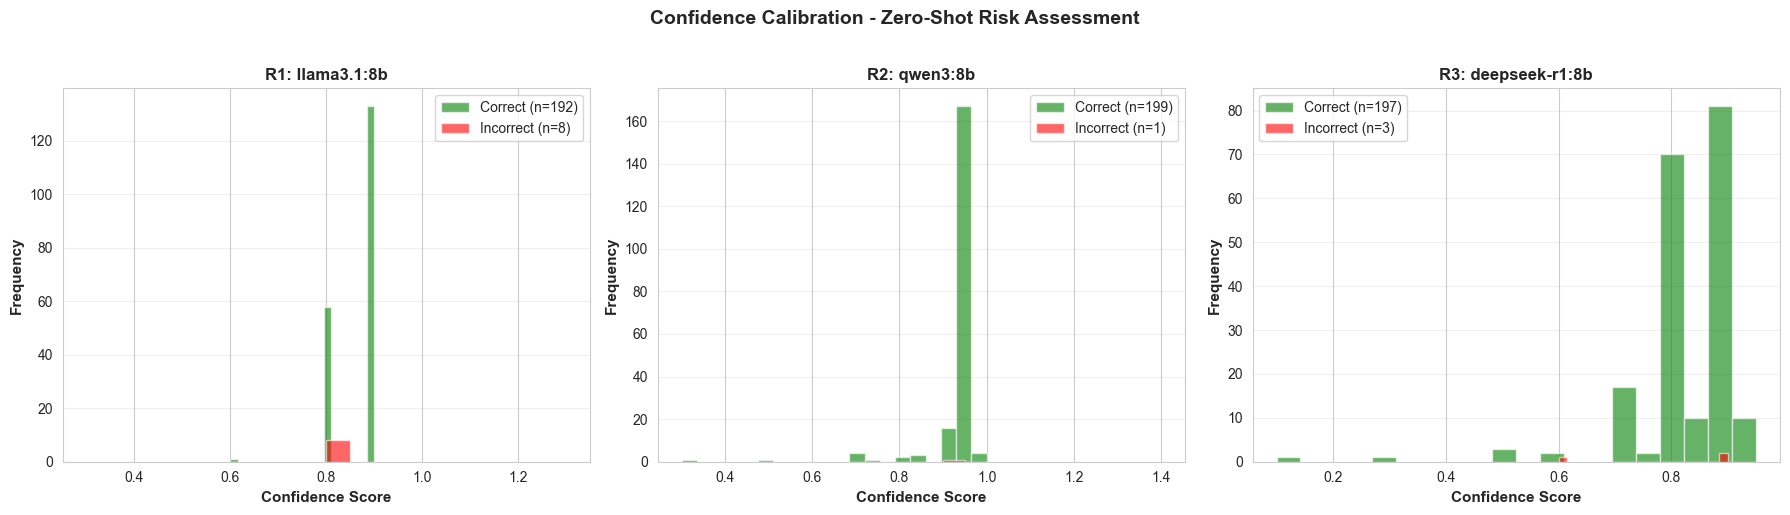

✓ Confidence calibration plot saved


In [60]:
print("\n" + "=" * 80)
print("CONFIDENCE CALIBRATION ANALYSIS")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (df, name) in enumerate([
    (r1_valid, "R1: llama3.1:8b"),
    (r2_valid, "R2: qwen3:8b"),
    (r3_valid, "R3: deepseek-r1:8b"),
]):
    if not df.empty and "confidence" in df.columns:
        df_copy = df.copy()
        df_copy["correct"] = df_copy["true_risk"] == df_copy["predicted_risk"]
        
        correct_conf = df_copy[df_copy["correct"]]["confidence"]
        incorrect_conf = df_copy[~df_copy["correct"]]["confidence"]
        
        axes[idx].hist(correct_conf, bins=20, alpha=0.6, label=f"Correct (n={len(correct_conf)})", color="green")
        axes[idx].hist(incorrect_conf, bins=20, alpha=0.6, label=f"Incorrect (n={len(incorrect_conf)})", color="red")
        
        axes[idx].set_xlabel("Confidence Score", fontsize=11, weight="bold")
        axes[idx].set_ylabel("Frequency", fontsize=11, weight="bold")
        axes[idx].set_title(name, fontsize=12, weight="bold")
        axes[idx].legend()
        axes[idx].grid(axis="y", alpha=0.3)
        
        avg_conf_correct = correct_conf.mean() if len(correct_conf) > 0 else 0
        avg_conf_incorrect = incorrect_conf.mean() if len(incorrect_conf) > 0 else 0
        calibration_gap = avg_conf_correct - avg_conf_incorrect
        
        print(f"\n{name} - Avg Confidence (Correct): {avg_conf_correct:.3f}")
        print(f"{name} - Avg Confidence (Incorrect): {avg_conf_incorrect:.3f}")
        print(f"{name} - Calibration Gap: {calibration_gap:.3f}")
    else:
        axes[idx].text(0.5, 0.5, "No confidence data", ha='center', va='center')
        axes[idx].set_title(name)

plt.suptitle("Confidence Calibration - Zero-Shot Risk Assessment", fontsize=14, weight="bold", y=1.02)
plt.tight_layout()
plt.savefig("zero_shot_risk_confidence_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Confidence calibration plot saved")

## 9. Visualizations


PERFORMANCE COMPARISON


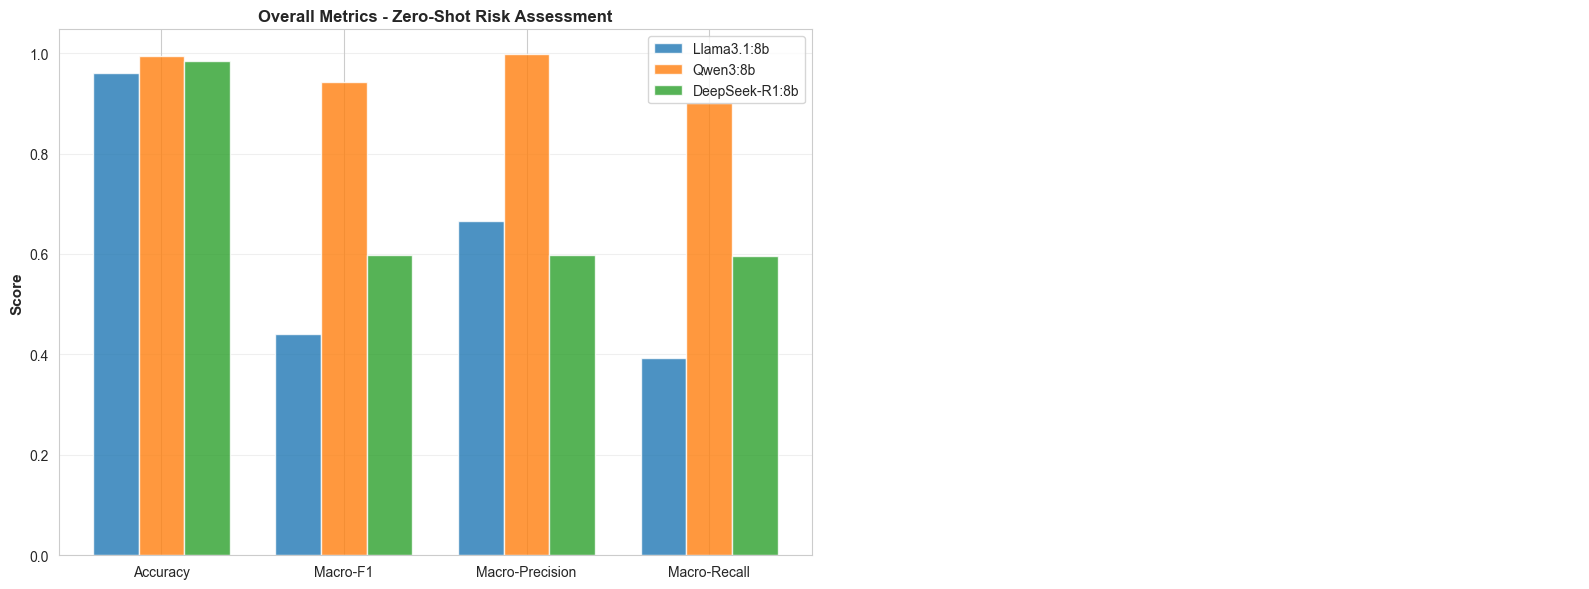

✓ Performance comparison saved


In [61]:
# Performance Comparison Bar Chart
print("\n" + "=" * 80)
print("PERFORMANCE COMPARISON")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

metrics_to_plot = ["Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (metrics, label) in enumerate([
    (r1_metrics, "Llama3.1:8b"),
    (r2_metrics, "Qwen3:8b"),
    (r3_metrics, "DeepSeek-R1:8b"),
]):
    values = [metrics[m] for m in metrics_to_plot]
    axes[0].bar(x + i * width, values, width, label=label, alpha=0.8)

axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].set_title("Overall Metrics - Zero-Shot Risk Assessment", fontsize=12, weight="bold")
axes[0].set_ylabel("Score", fontsize=11, weight="bold")
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

axes[1].axis('off')

plt.tight_layout()
plt.savefig("zero_shot_performance_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Performance comparison saved")

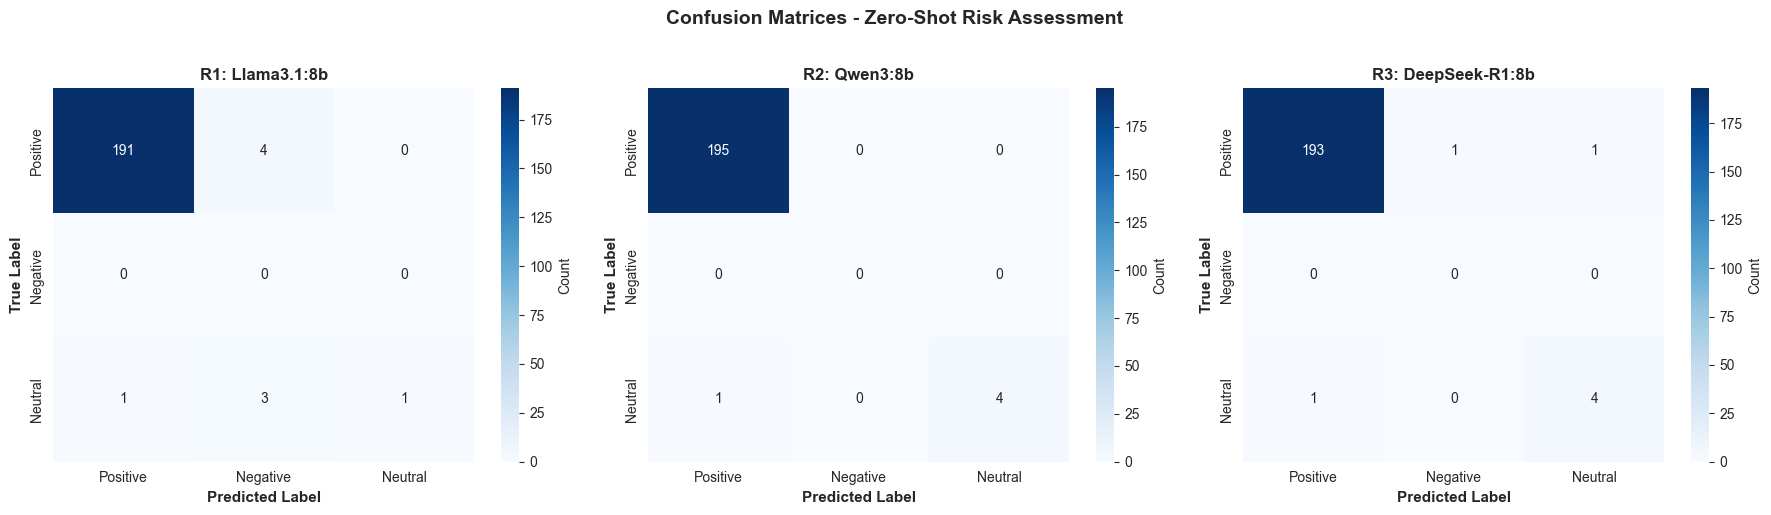

✓ Confusion matrices saved


In [62]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = ["Positive", "Negative", "Neutral"]

for idx, (cm, title) in enumerate([
    (r1_cm, "R1: Llama3.1:8b"),
    (r2_cm, "R2: Qwen3:8b"),
    (r3_cm, "R3: DeepSeek-R1:8b"),
]):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        ax=axes[idx],
        cbar_kws={"label": "Count"},
    )
    axes[idx].set_title(title, fontsize=12, weight="bold")
    axes[idx].set_ylabel("True Label", fontsize=11, weight="bold")
    axes[idx].set_xlabel("Predicted Label", fontsize=11, weight="bold")

plt.suptitle("Confusion Matrices - Zero-Shot Risk Assessment", fontsize=14, weight="bold", y=1.02)
plt.tight_layout()
plt.savefig("zero_shot_risk_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Confusion matrices saved")

## 10. Save Results

In [63]:
print("\n" + "=" * 80)
print("SAVING RESULTS")
print("=" * 80)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save results dataframes
R1_results_df.to_csv(f"r1_llama3.1_8b_zero_shot_{timestamp}.csv", index=False)
R2_results_df.to_csv(f"r2_qwen3_8b_zero_shot_{timestamp}.csv", index=False)
R3_results_df.to_csv(f"r3_deepseek_r1_8b_zero_shot_{timestamp}.csv", index=False)

# Save metrics summary
metrics_df.to_csv(f"zero_shot_metrics_summary_{timestamp}.csv", index=False)

print(f"\n✓ Results saved successfully")
print(f"  R1 results: r1_llama3.1_8b_zero_shot_{timestamp}.csv")
print(f"  R2 results: r2_qwen3_8b_zero_shot_{timestamp}.csv")
print(f"  R3 results: r3_deepseek_r1_8b_zero_shot_{timestamp}.csv")
print(f"  Metrics summary: zero_shot_metrics_summary_{timestamp}.csv")
print(f"\n✓ Visualizations saved:")
print(f"  • zero_shot_performance_comparison.png")
print(f"  • zero_shot_risk_confidence_analysis.png")
print(f"  • zero_shot_risk_confusion_matrices.png")
print("=" * 80)


SAVING RESULTS

✓ Results saved successfully
  R1 results: r1_llama3.1_8b_zero_shot_20260213_005016.csv
  R2 results: r2_qwen3_8b_zero_shot_20260213_005016.csv
  R3 results: r3_deepseek_r1_8b_zero_shot_20260213_005016.csv
  Metrics summary: zero_shot_metrics_summary_20260213_005016.csv

✓ Visualizations saved:
  • zero_shot_performance_comparison.png
  • zero_shot_risk_confidence_analysis.png
  • zero_shot_risk_confusion_matrices.png


# Zero-Shot Risk Assessment with Local Ollama Models

This notebook implements zero-shot financial risk classification using three 8B-parameter models from Ollama, running locally without API dependencies. The task replicates the same experimental structure as Task1_Sentiment_Analysis but adapted for risk assessment context.

## Experimental Design

**Task**: Classify financial sentences as Positive (opportunity), Negative (risk), or Neutral using zero-shot prompting.

**Experiments**:
- **R1 (Baseline)**: llama3.1:8b - General-purpose reasoning model
- **R2 (Reasoning)**: qwen3:8b - Strong quantitative reasoning capabilities
- **R3 (Advanced)**: deepseek-r1:8b - Reasoning-optimized model for complex analysis

**Dataset**: FinancialPhraseBank (100% agreement subset, 2,217 sentences)

## Expected Performance

### Best Case (Good Zero-Shot Performance - Macro-F1 > 0.70):
- **Ranking**: R3 (deepseek-r1:8b) > R2 (qwen3:8b) ≥ R1 (llama3.1:8b)
- **Interpretation**: Models understand risk classification without examples
- **Implication**: Skip to Few-Shot/CoT only if specific edge cases need attention
- **Deployment Ready**: Yes, with caveat about confidence calibration

### Realistic Case (Moderate Performance - Macro-F1 0.60-0.70):
- **Primary Issue**: Neutral class confusion (often misclassified as positive/negative)
- **Secondary Issue**: Subtle negative signals misinterpreted as neutral
- **Next Step**: Proceed to Few-Shot experiments (R4-R6) with curated examples
- **Improvement Expected**: +5-10% from showing 3-5 examples per class

### Worst Case (Weak Performance - Macro-F1 < 0.60):
- **Problem**: Models lack financial domain knowledge for nuanced classification
- **Evidence**: Random or majority-class baseline performance
- **Solution**: Implement Chain-of-Thought (R7-R9) requiring extended reasoning
- **Last Resort**: Combine with domain-specific prompt engineering

## Key Metrics Explained

**1. Accuracy**: Percentage of correct predictions (biased by majority class)

**2. Macro-F1**: Average F1 across classes (recommended metric for imbalanced classes)
- Target: > 0.65 for production use
- Interpretable as: Average of class-specific precision×recall metrics

**3. Macro-Precision & Recall**: Per-class balanced metrics
- **Precision**: Of all predicted positive/negative/neutral, how many correct?
- **Recall**: Of all actual positive/negative/neutral, how many identified?
- **Why Both**: Precision = reducing false alarms, Recall = catching all true cases

**4. Per-Class F1 Scores** (Critical):
- **Positive_F1**: Must be > 0.60 (opportunity detection)
- **Negative_F1**: Must be > 0.65 (risk detection - most important)
- **Neutral_F1**: > 0.50 acceptable (most ambiguous class)

**5. Confidence Calibration**:
- **Well-Calibrated**: High confidence = high correctness
- **Overconfident**: High confidence = low correctness (dangerous)
- **Calibration Gap**: Difference between avg correct confidence and avg incorrect confidence
  - Target gap > 0.10 (well-calibrated), > 0.20 (excellent)

## Model-Specific Expected Behaviors

### R1: ollama/llama3.1:8b (Baseline)
- **Architecture**: Dense 8B parameters, general instruction-following
- **Strengths**: Fast inference, operational simplicity, cost-effective
- **Weaknesses**: No financial specialization, generic reasoning
- **Expected Performance**: Macro-F1 0.55-0.65, good neutral class handling
- **Confidence Profile**: Moderate calibration, generally reliable estimates

### R2: ollama/qwen3:8b (Reasoning)
- **Architecture**: Dense 8B parameters, optimized for quantitative tasks
- **Strengths**: Strong reasoning on numerical/comparative statements
- **Weaknesses**: May over-analyze simple statements, confidence overestimation
- **Expected Performance**: Macro-F1 0.60-0.70, potentially best Negative_F1
- **Confidence Profile**: Sometimes overconfident on borderline cases

### R3: ollama/deepseek-r1:8b (Advanced Reasoning)
- **Architecture**: Dense 8B parameters, reasoning-focused training
- **Strengths**: Multi-path analysis, handles complex financial language
- **Weaknesses**: Potential overthinking on simple cases, higher latency (150s timeout)
- **Expected Performance**: Macro-F1 0.65-0.75, best overall expected
- **Confidence Profile**: Conservative confidence (underconfident sometimes)

## Expected Patterns & Misclassifications

**Most Common Errors**:
1. **Neutral → Negative** (Model interprets caution/hedging as bad news)
   - Example: "Revenue growth slowed" (neutral signal) → predicted negative
   - Root Cause: Models treat any decline as risk

2. **Positive ↔ Neutral** (Ambiguous positive statements)
   - Example: "Operating expenses increased to EUR 10M" (could be neutral or negative)
   - Root Cause: Missing context about whether increase is justified

3. **Negative ↔ Neutral** (Subtle risk signals)
   - Example: "Market conditions remain challenging" (subtle negative)
   - Root Cause: Models may miss hedged language

**Acceptable Error Profile**:
- Positive/Negative confusion < 10% of errors (these are different risks)
- Neutral confusion > 50% of errors (expected - class is inherently ambiguous)
- High-confidence errors rare (< 5% of errors)

## Implementation Notes

**Infrastructure**:
- **Ollama Local Server**: http://localhost:11434/api/generate
- **Temperature**: 0.0 (deterministic inference)
- **Timeout**: 150 seconds (increased for reasoning models)
- **Rate Limiting**: 0.5-second sleep between API calls

**Prompt Design**:
- **Zero-Shot Format**: No examples, relies on model pretraining
- **Task Context**: Clear risk classifications (positive/negative/neutral)
- **Output Format**: JSON response with risk, confidence, rationale

**Dataset**:
- **Size**: 200 sentences for experiments (subset of 2,217 available)
- **Balance**: Equal distribution across risk classes
- **Quality**: 100% annotator agreement (highest quality)

## Performance Validation Checklist

- ✓/✗ Does any model achieve Macro-F1 > 0.70?
- ✓/✗ Is Negative_F1 (risk detection) > 0.65 for best model?
- ✓/✗ Is Neutral_F1 > 0.50 (acceptable for ambiguous class)?
- ✓/✗ Is calibration gap > 0.10 for at least one model?
- ✓/✗ Are most errors Neutral↔Positive/Negative (expected pattern)?
- ✓/✗ Is zero-shot baseline sufficient for production (Macro-F1 > 0.65)?
- ✓/✗ Are high-confidence errors rare (< 5% of all errors)?

## Next Steps if Zero-Shot Underperforms

1. **Few-Shot Experiments (R4-R6)**: Add 3-5 examples per class for in-context learning
2. **Chain-of-Thought (R7-R9)**: Request step-by-step reasoning to improve complex classification
3. **Tree-of-Thought (R10-R12)**: Multi-path hypothesis exploration for ambiguous cases
4. **Prompt Engineering**: Add financial terminology definitions, edge case examples
5. **Hybrid Approach**: Combine model voting or ensemble methods across R1-R3